## 資料集說明

- **檔名**：`Social_Network_Ads.csv`
- **欄位**：
    - `Age`：年齡
    - `EstimatedSalary`：預估薪資
    - `Purchased`：是否購買（目標變數，0 或 1）

In [2]:
# 匯入套件及讀取資料
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('Social_Network_Ads.csv')
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [5]:
# 特徵與目標變數分離

x=df.drop(columns='Purchased')
y=df['Purchased']

In [6]:
# 資料切分為訓練及測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [7]:
# 特徵標準化 (Standard Scaling)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [8]:
# 決策樹分類器建模與訓練
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train_sc, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [9]:
# 預測與模型評估
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
y_pred = classifier.predict(X_test_sc)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.9
F1 Score: 0.8260869565217391


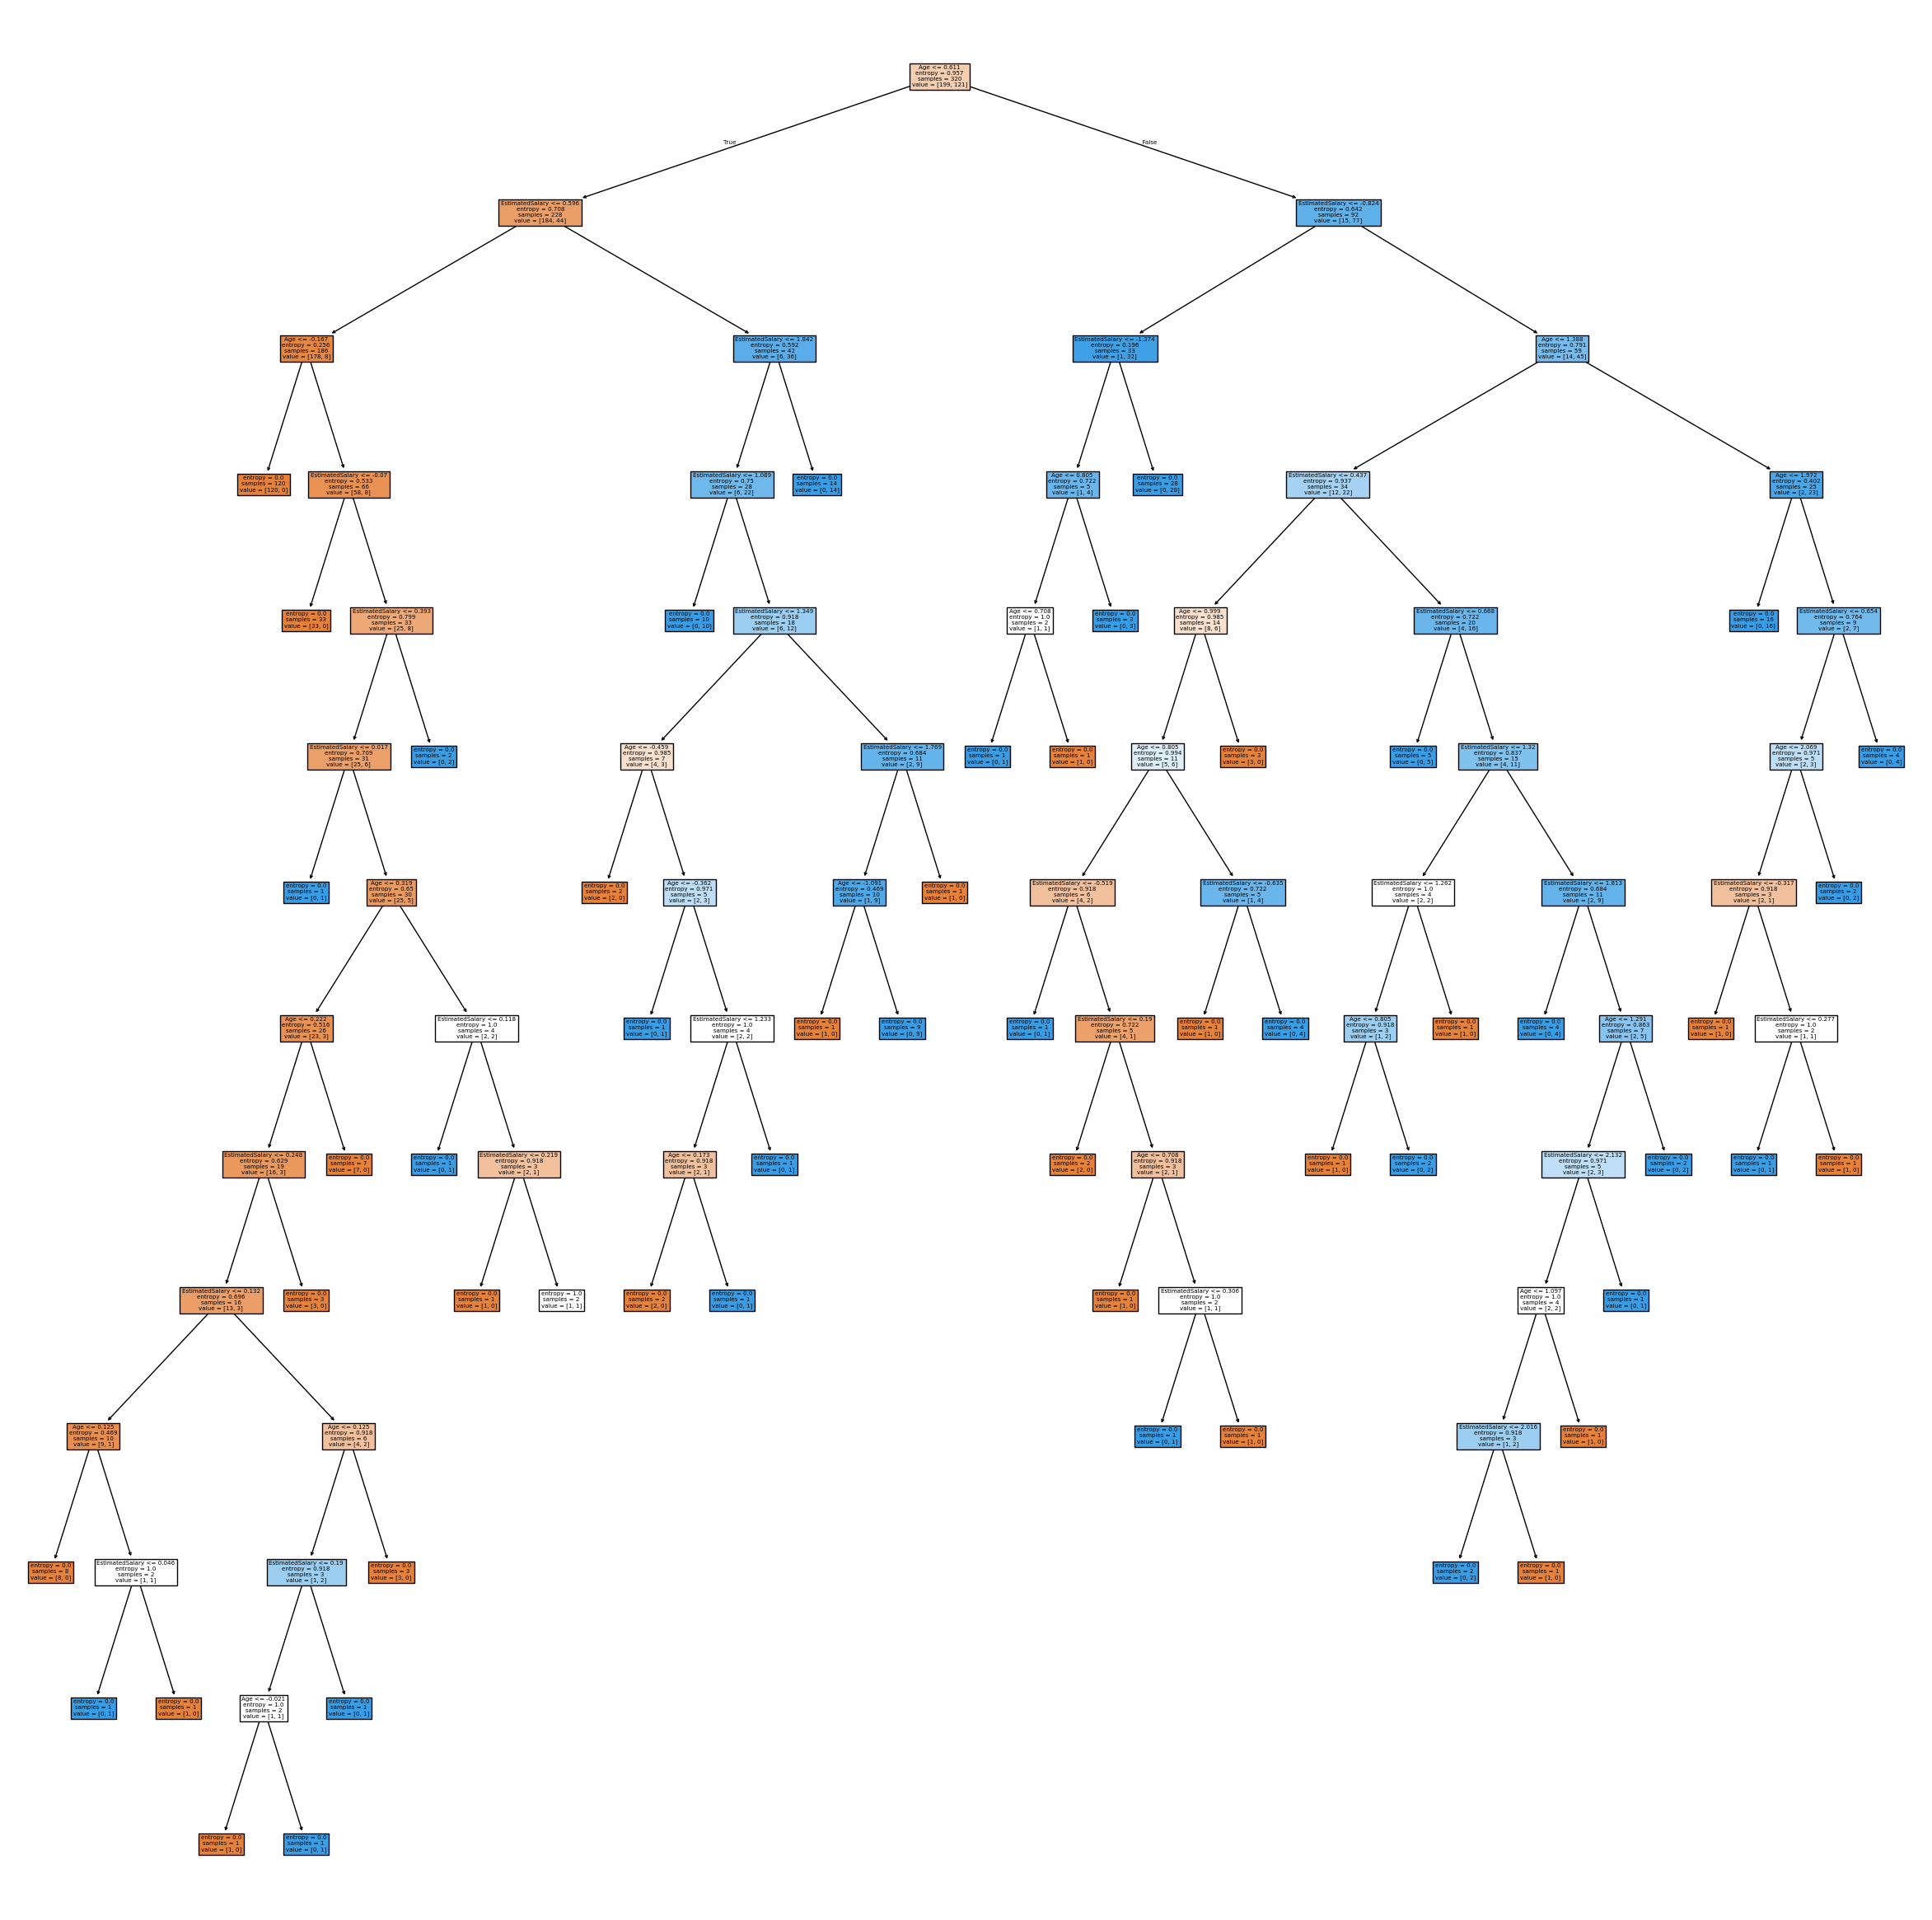

In [10]:
# 視覺化決策樹結構
from sklearn.tree import plot_tree
plt.figure(figsize=(30,30))
plot_tree(classifier, filled=True, feature_names=x.columns)
plt.show()

In [19]:
# 過擬合觀察
# 比較訓練柔測試集上的 F1 Score
y_pred_train = classifier.predict(X_train_sc)
print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('F1 Score:', f1_score(y_train, y_pred_train))


Accuracy: 0.996875
F1 Score: 0.995850622406639


### 結論

- **過擬合現象明顯**：模型在訓練集表現非常好（幾乎完美），但在測試集下降明顯
- **可能原因**：
    - 未限制決策樹深度（`max_depth`）
    - 未進行參數調整

## 決策樹 (Decision Tree) 的超參數搜尋與交叉驗證

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
# 建立基礎模型

tree = DecisionTreeClassifier(random_state=42)

# 定義 hyperparameter 搜尋範圍
param_grid = {
    "criterion": ["gini", "entropy", "log-loss"],
    "max_depth": [2, 4, 5, 6],
    "min_samples_split": [4, 2 ,6]
}

criterion: 決策樹分裂節點的準則。

"gini" → Gini 指數。

"entropy" → 資訊增益。

"log_loss" → 對數損失，對機率預測更敏感。

max_depth: 決策樹的最大深度 (限制避免過擬合)。

min_samples_split: 節點分裂所需的最小樣本數。

總組合數 = 3 * 4 * 3 = 36。

In [26]:
# 定義 GridSearchCV
grid=GridSearchCV(
    tree,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
    )

GridSearchCV: 會把模型和超參數組合逐一嘗試。

cv=5: 使用 5 折交叉驗證。

scoring='accuracy': 評估準則為分類正確率。

verbose=1: 訓練過程會輸出進度資訊。

In [28]:
# 開始訓練
grid.fit(X_train_sc, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log-loss'],
                         'max_depth': [2, 4, 5, 6],
                         'min_samples_split': [4, 2, 6]},
             scoring='accuracy', verbose=1)

In [29]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_split=4, random_state=42)

In [30]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4}

In [31]:
grid.best_score_


np.float64(0.9)

使用隨機搜尋 (RandomizedSearchCV) 來找決策樹的最佳超參數。和 GridSearchCV 不同的是，它不是窮舉所有組合，而是隨機抽樣部分組合進行交叉驗證。

In [33]:
# Randomsearch
from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeClassifier(random_state=42)
param_grid = {"criterion":["gini", "entropy", "log_loss"],
             "max_depth":[2,4,5,6],
             "min_samples_split":[4,2,6]}
random = RandomizedSearchCV(tree, cv=5,param_distributions=param_grid,scoring='accuracy',verbose=1)
random.fit(X_train_sc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 4, 5, 6],
                                        'min_samples_split': [4, 2, 6]},
                   scoring='accuracy', verbose=1)

In [34]:
random.best_params_

{'min_samples_split': 2, 'max_depth': 4, 'criterion': 'entropy'}

In [35]:
random.best_score_


np.float64(0.865625)